CODE BLOCK: 1

In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary  #

CODE BLOCK: 2

In [2]:
# Device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print("Device Selected:", device)

Device Selected: mps


CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  #
])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)  #

CODE BLOCK: 5

In [5]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'num_workers': 2, 'pin_memory': True}  #

test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, **kwargs)  #
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, **kwargs)

CODE BLOCK: 6

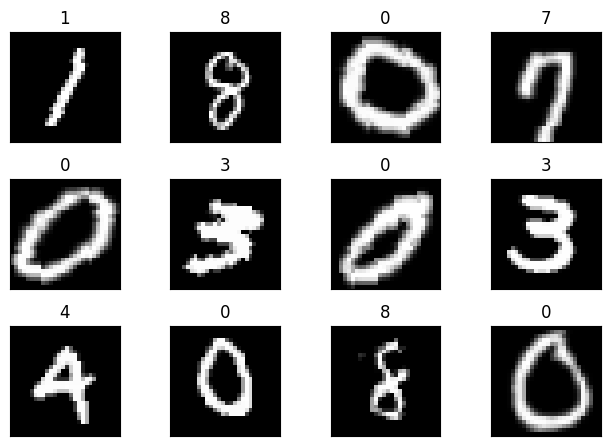

In [6]:
from utils import plot_examples
plot_examples(train_loader)

CODE BLOCK: 7

In [7]:
from model import Net

model = Net().to(device)
model.summary(input_size=(1, 28, 28))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
Net                                      [1, 28, 28]               [1, 10]                   --                             --
├─Conv2d: 1-1                            [1, 28, 28]               [32, 26, 26]              320                         0.05%
├─Conv2d: 1-2                            [32, 26, 26]              [64, 24, 24]              18,496                      3.12%
├─Conv2d: 1-3                            [64, 12, 12]              [128, 10, 10]             73,856                     12.45%
├─Conv2d: 1-4                            [128, 10, 10]             [256, 8, 8]               295,168                    49.76%
├─Linear: 1-5                            [1, 4096]                 [1, 50]                   204,850                    34.53%
├─Linear: 1-6                            [1, 50]                   [1, 10]                   510               

CODE BLOCK: 8

In [8]:
from utils import train, test, plot_stats

CODE BLOCK: 9

In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  #
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.cross_entropy
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)  #
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.6267 Batch_id=117 Accuracy=27.35: 100%|██████████| 118/118 [00:25<00:00,  4.72it/s]


Test set: Average loss: 1.5644, Accuracy: 5045/10000 (50.45%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2347 Batch_id=117 Accuracy=83.73: 100%|██████████| 118/118 [00:25<00:00,  4.64it/s]


Test set: Average loss: 0.1633, Accuracy: 9512/10000 (95.12%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1657 Batch_id=117 Accuracy=94.67: 100%|██████████| 118/118 [00:25<00:00,  4.61it/s]


Test set: Average loss: 0.0793, Accuracy: 9748/10000 (97.48%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0737 Batch_id=117 Accuracy=96.36: 100%|██████████| 118/118 [00:27<00:00,  4.29it/s]


Test set: Average loss: 0.0624, Accuracy: 9806/10000 (98.06%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0739 Batch_id=117 Accuracy=97.07: 100%|██████████| 118/118 [00:26<00:00,  4.50it/s]


Test set: Average loss: 0.0589, Accuracy: 9813/10000 (98.13%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0257 Batch_id=117 Accuracy=97.36: 100%|██████████| 118/118 [00:24<00:00,  4.82it/s]


Test set: Average loss: 0.0439, Accuracy: 9854/10000 (98.54%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.1597 Batch_id=117 Accuracy=97.75: 100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


Test set: Average loss: 0.0423, Accuracy: 9858/10000 (98.58%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1084 Batch_id=117 Accuracy=97.97: 100%|██████████| 118/118 [00:24<00:00,  4.86it/s]


Test set: Average loss: 0.0450, Accuracy: 9842/10000 (98.42%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0428 Batch_id=117 Accuracy=98.12: 100%|██████████| 118/118 [00:24<00:00,  4.86it/s]


Test set: Average loss: 0.0347, Accuracy: 9888/10000 (98.88%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0114 Batch_id=117 Accuracy=98.38: 100%|██████████| 118/118 [00:25<00:00,  4.61it/s]


Test set: Average loss: 0.0348, Accuracy: 9893/10000 (98.93%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0140 Batch_id=117 Accuracy=98.38: 100%|██████████| 118/118 [00:24<00:00,  4.79it/s]


Test set: Average loss: 0.0291, Accuracy: 9895/10000 (98.95%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0811 Batch_id=117 Accuracy=98.54: 100%|██████████| 118/118 [00:24<00:00,  4.88it/s]


Test set: Average loss: 0.0301, Accuracy: 9903/10000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0321 Batch_id=117 Accuracy=98.58: 100%|██████████| 118/118 [00:24<00:00,  4.91it/s]


Test set: Average loss: 0.0302, Accuracy: 9904/10000 (99.04%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0750 Batch_id=117 Accuracy=98.67: 100%|██████████| 118/118 [00:25<00:00,  4.66it/s]


Test set: Average loss: 0.0252, Accuracy: 9918/10000 (99.18%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0343 Batch_id=117 Accuracy=98.78: 100%|██████████| 118/118 [00:26<00:00,  4.45it/s]


Test set: Average loss: 0.0301, Accuracy: 9896/10000 (98.96%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0098 Batch_id=117 Accuracy=98.95: 100%|██████████| 118/118 [00:24<00:00,  4.88it/s]


Test set: Average loss: 0.0218, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0424 Batch_id=117 Accuracy=98.99: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


Test set: Average loss: 0.0216, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0371 Batch_id=117 Accuracy=99.03: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


Test set: Average loss: 0.0218, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0138 Batch_id=117 Accuracy=99.08: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


Test set: Average loss: 0.0213, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0920 Batch_id=117 Accuracy=99.09: 100%|██████████| 118/118 [00:28<00:00,  4.07it/s]


Test set: Average loss: 0.0214, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-03.


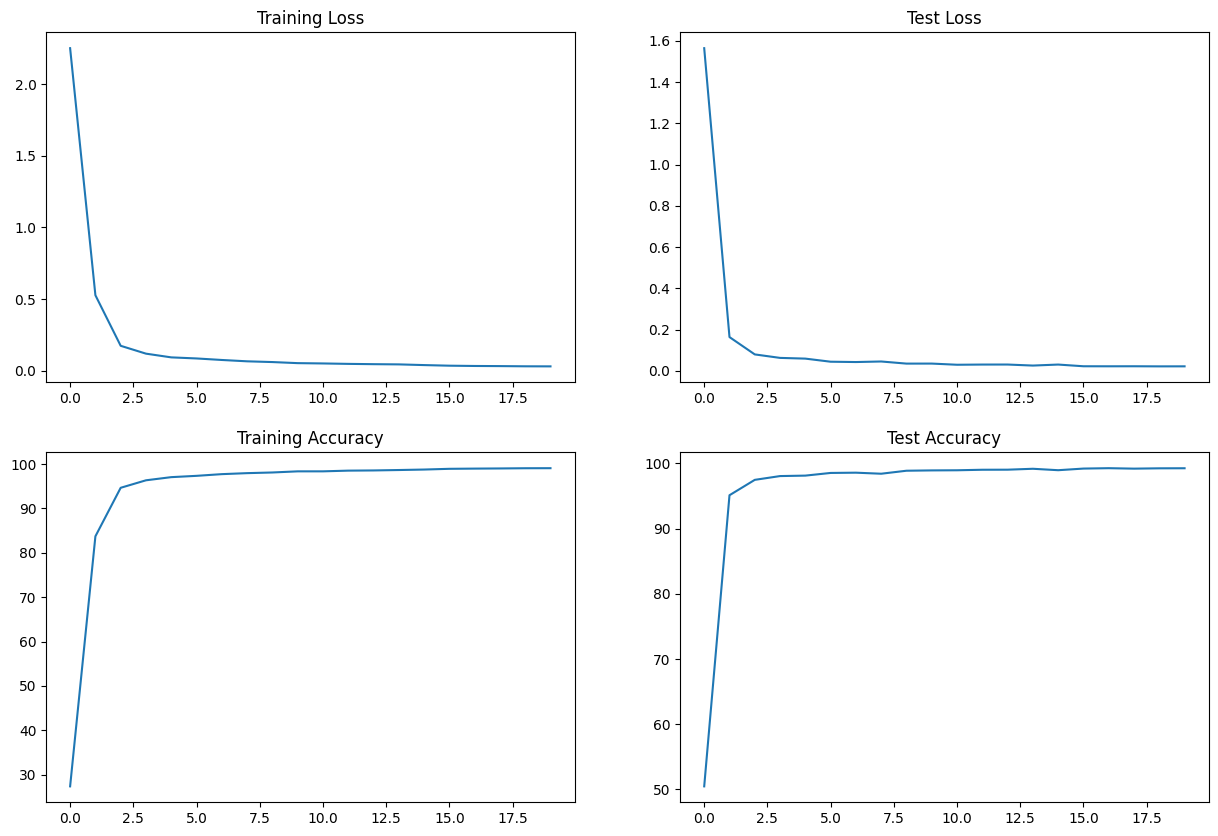

In [10]:
plot_stats()

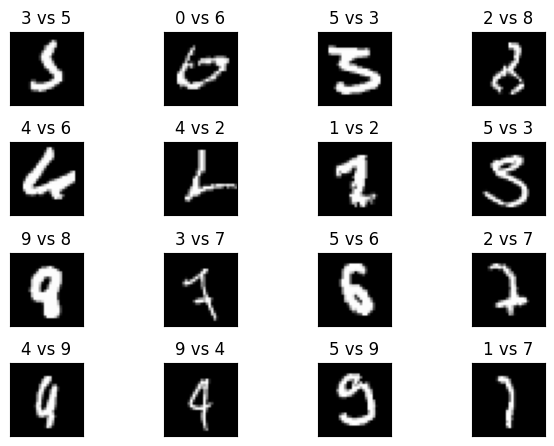

In [11]:
from utils import test_show_incorrect
test_show_incorrect(model, device, test_loader) # Predicted vs Actual